<a href="https://colab.research.google.com/github/Anshulnagar00/Face-Recognition-API/blob/master/FaceRecognitionAPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Necessary Installs & Imports
> face_recognition requires GPU Support

In [1]:
!pip install dlib face_recognition mtcnn gevent

     |████████████████████████████████| 2.3MB 7.3MB/s 
     |████████████████████████████████| 5.2MB 58.3MB/s 
     |████████████████████████████████| 100.2MB 30kB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566172 sha256=20debda5716f7ec796f6e7817d8711f79e4719a9ea3eee601c6dc2e0496de881
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [2]:
from __future__ import division, print_function
# coding=utf-8
import sys
import os
import numpy as np

# Flask utils
from flask import Flask, redirect, url_for, request, render_template
from werkzeug.utils import secure_filename

# ngrok
import atexit
import json
import platform
import shutil
import subprocess
import tempfile
import time
import zipfile
from pathlib import Path
from threading import Timer
import requests
import urllib

#later 
import cv2
from gevent.pywsgi import WSGIServer

# image 2 datauri

from PIL import Image
import io
import base64

# mtcnn classifier
from numpy import asarray
from mtcnn.mtcnn import MTCNN

import time

from imutils import paths
import imutils
import pickle
import matplotlib.pyplot as plt
import face_recognition
from numpy import asarray


Using TensorFlow backend.


# ngrok - Setup

In [0]:
def get_command():
    system = platform.system()
    if system == "Darwin":
        command = "ngrok"
    elif system == "Windows":
        command = "ngrok.exe"
    elif system == "Linux":
        command = "ngrok"
    else:
        raise Exception("{system} is not supported".format(system=system))
    return command


def run_ngrok(port):
    command = get_command()
    ngrok_path = str(Path(tempfile.gettempdir(), "ngrok"))
    download_ngrok(ngrok_path)
    executable = str(Path(ngrok_path, command))
    os.chmod(executable, 0o777)
    ngrok = subprocess.Popen([executable, 'http', str(port)])
    atexit.register(ngrok.terminate)
    localhost_url = "http://localhost:4040/api/tunnels"  # Url with tunnel details
    time.sleep(1)
    tunnel_url = requests.get(localhost_url).text  # Get the tunnel information
    j = json.loads(tunnel_url)

    tunnel_url = j['tunnels'][0]['public_url']  # Do the parsing of the get
    tunnel_url = tunnel_url.replace("https", "http")
    return tunnel_url


def download_ngrok(ngrok_path):
    if Path(ngrok_path).exists():
        return
    system = platform.system()
    if system == "Darwin":
        url = "https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-darwin-amd64.zip"
    elif system == "Windows":
        url = "https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-windows-amd64.zip"
    elif system == "Linux":
        url = "https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip"
    else:
        raise Exception(f"{system} is not supported")
    download_path = download_file(url)
    with zipfile.ZipFile(download_path, "r") as zip_ref:
        zip_ref.extractall(ngrok_path)


def download_file(url):
    local_filename = url.split('/')[-1]
    r = requests.get(url, stream=True)
    download_path = str(Path(tempfile.gettempdir(), local_filename))
    with open(download_path, 'wb') as f:
        shutil.copyfileobj(r.raw, f)
    return download_path


def start_ngrok(port):
    cv=True
    ngrok_address = run_ngrok(port)
    data=ngrok_address
    if cv:
      f=open("Logs.txt",'w')
      f.write(data)
      f.close()
      cv=False
    print(f" * Running on {ngrok_address}")
    print(f" * Traffic stats available on http://127.0.0.1:4040")
    



def run_with_ngrok(app):
    """
    The provided Flask app will be securely exposed to the public internet via ngrok when run,
    and the its ngrok address will be printed to stdout
    :param app: a Flask application object
    :return: None
    """
    old_run = app.run

    def new_run(*args, **kwargs):
        port = kwargs.get('port', 5000)
        thread = Timer(1, start_ngrok, args=(port,))
        thread.setDaemon(True)
        thread.start()
        old_run(*args, **kwargs)
    app.run = new_run

# Firebase - Setup

In [0]:
import firebase_admin
from firebase_admin import credentials
from firebase_admin import db

# Fetch the service account key JSON file contents
cred = credentials.Certificate('drive/My Drive/FaceRecog/face-recognition-api-329bf-firebase-adminsdk-osjjv-a075fb4a6c.json')

# Initialize the app with a service account, granting admin privileges
firebase_admin.initialize_app(cred, {
    'databaseURL': 'https://face-recognition-api-329bf.firebaseio.com/'
})

# As an admin, the app has access to read and write all data, regradless of Security Rules
ref = db.reference('restricted_access/secret_document')

In [0]:
def add_new_user(name,password):
    names = list(db.reference('users').get().values())
    if names.count(name) == 0:
        users = db.reference('users')
        users.push(name)
        userdata = db.reference('userdata').child(name)
        userdata.child("password").set(password)
        print("[INFO] User "+name+" added sucessfully")
        return (1,"User added sucessfully",name)
    else:
        print("[ERROR] Username already exist")
        return (0,"Username already exist",name)

def verify_user(name,password):
  names = list(db.reference('users').get().values())
  if names.count(name) == 1:
    if db.reference('userdata').child(name).child("password").get() == password :
      return 1
    else :
      return 0
  else :
    return 0

def set_data(name,password,bytearraydata):
  if verify_user(name,password) == 0 :
    return 0
  datab64 = base64.encodebytes(bytearraydata)
  data = datab64.decode('utf-8')
  db.reference('userdata').child(name).child("facedata").set(data)
  return 1

def get_data(name,password):
  if verify_user(name,password) == 0 :
    return (0,"Invalid username/password",None)
  bytestr = db.reference('userdata').child(name).child("facedata").get()
  if bytestr == None :
    return (0,"No faces added",None)
  response = urllib.request.urlopen("data:image/png;base64,"+bytestr)
  data = response.file.read()
  return (1,"Success",data)


# Application functions

In [0]:
def add_face(name,image,username="GLOBAL",password="GLOBAL"):
  '''
  Face_Recognition_API by Anshul Nagar
  
  > Function : Register face from image having only one face 
  
  > Input : 

  name - name of the person in image

  img - image array in RGB color channel

  username - (OPTIONAL) to save face data separated

  password - (OPTIONAL) to save face data separated

  > Returns : a tuple of following data `(Success_Code,Description,Result_Data)

  Success_Code - 1 for Success 0 for Failure 
  
  Description - Success or Failure Description

  Result_Data - name of the person 
  
  '''

  # Face Detection using Mtcnn
  detector = MTCNN()
  facesd = len(detector.detect_faces(image))
  if facesd != 1 :
    print("[ERROR] No or Multiple Faces Detected")
    return (0,"No or multiple faces detected",facesd)

  # create the detector, using default weights
  # load the known faces and embeddings

  # scanning uploaded image
  
  print("[INFO] Scanning face...")
  try :
    results = scan_face(image,username,password)
    res02 = results[2]
    if len(res02) != 0 :
      print("[ERROR] Face already registered as name "+res02[0][1])
      return (0,"Face already registered",res02[0][1])
    data = results[3]
  except :

    data = {"encodings":[],"names":[]}
  
  rgb = image.copy()
	# detect the (x, y)-coordinates of the bounding boxes
	# corresponding to each face in the input image
  boxes = face_recognition.face_locations(rgb,model="cnn")
  # compute the facial embedding for the face
  encodings = face_recognition.face_encodings(rgb, boxes)
  # loop over the encodings
  knownEncodings = []
  knownNames = []
  for encoding in encodings:
    # add each encoding + name to our set of known names and encodings
    knownEncodings.append(encoding)
    knownNames.append(name)
  # dump the facial encodings + names to disk
  print("[INFO] serializing encodings...")
  new = {"encodings": knownEncodings, "names": knownNames}
  for i in range(len(new['names'])):
    data['encodings'].append(new['encodings'][i])
    data['names'].append(new['names'][i])
  
  set_data(username,password,pickle.dumps(data))
  print("[INFO] Face of {} added Sucessfully".format(name))
  return (1,"Face added sucessfully",name)




def delete(lst,indexes):
  '''
  Face_Recognition_API by Anshul Nagar

  > Function : Returns deleted list  

  > Input : 

  lst - list

  indexes - list of index

  > Output : list having elements with index which is not in indexes list

  > Example : 

  >> ls = [2,4,6,3,8,2,4,6]

  >> ls = delete(ls,[1,5,3])

  >> print(ls)

  >>> [2,6,8,4,6] 
  
  '''
  ls = lst.copy()
  indexes.sort()
  for i,v in enumerate(indexes):
    ls.pop(v-i)
  return ls


def remove_face(name,username="GLOBAL",password="GLOBAL"):

  '''
  Face_Recognition_API by Anshul Nagar
  
  > Function : Removes all face-encodings associated with name

  > Input : 
  
  name - String (name of person)

  username - (OPTIONAL) to save facedata separated

  password - (OPTIONAL) to save facedata separated

  > Returns : a tuple of following data `(Success_Code,Description,Result_Data)

  Success_Code - 1 for Success 0 for Failure 
  
  Description - Success or Failure Description
  
  Result_Data - name of person

  '''
  
  print("[INFO] loading encodings...")
  try :
    DATA = get_data(username,password)
    if DATA[0] == 0 :
      return (0,DATA[1],"")
    data = pickle.loads(DATA[2])
  except :
    print("[ERROR] No Data !")
    return (0,"No data !","")
  idx = [i for i in range(len(data['names'])) if data['names'][i] == name]
  if len(idx)==0:
    print("[ERROR] No face detected having name {}".format(name))
    return (0,"Face not found",name)
  print("[INFO] Removing {} ...".format(name))
  for i in range(len(data['names'])):
      enc = delete(data['encodings'],indexes=idx)
      nam = delete(data['names'],indexes=idx)
  f_data = {"encodings":enc,"names":nam}
  set_data(username,password,pickle.dumps(f_data))
  print("[INFO] Done")
  return (1,"Face removed sucessfully",name)


def scan_face(img,username="GLOBAL",password="GLOBAL"):

  '''
  Face_Recognition_API by Anshul Nagar
  
  > Function : Recognize faces in the input image
  
  > Input : 
  
  img - image array in RGB color channel

  username - (OPTIONAL) to save facedata separated

  password - (OPTIONAL) to save facedata separated

  > Returns : a tuple of following data `(Success_Code,Description,Result_Data,Encodings_Data)

  Success_Code - 1 for Success 0 for Failure 
  
  Description - Success or Failure Description
  
  Result_Data - 
  Array of Results in the Following format -
  [((top, right, bottom, left), name),((top, right, bottom, left), name), ...... ,((top, right, bottom, left), name)]

  Encodings_Data - Only Provided for use in other functions (not to be shared to user)

  '''

  result = []
  rgb = img.copy()
  # Face Detection using Mtcnn
  detector = MTCNN()
  if len(detector.detect_faces(img)) == 0 :
    print("[ERROR] No Faces Detected !")
    return (0,"No Faces Detected !",[])
  # load the known faces and embeddings
  print("[INFO] loading encodings...")
  DATA = get_data(username,password)
  if DATA[0] == 0 :
    return (0,DATA[1],[])
  data = pickle.loads(DATA[2])
  # detect the (x, y)-coordinates of the bounding boxes corresponding
  # to each face in the input image, then compute the facial embeddings
  # for each face
  print("[INFO] recognizing faces...")
  boxes = face_recognition.face_locations(rgb,model="cnn")
  encodings = face_recognition.face_encodings(rgb, boxes)
  # initialize the list of names for each face detected
  names = []
  # loop over the facial embeddings
  for encoding in encodings:
    # attempt to match each face in the input image to our known
    # encodings
    matches = face_recognition.compare_faces(data["encodings"],encoding)
    name = "Unknown"
    # check to see if we have found a match
    if True in matches:
      # find the indexes of all matched faces then initialize a
      # dictionary to count the total number of times each face
      # was matched
      matchedIdxs = [i for (i, b) in enumerate(matches) if b]
      counts = {}
      # loop over the matched indexes and maintain a count for
      # each recognized face face
      for i in matchedIdxs:
        name = data["names"][i]
        counts[name] = counts.get(name, 0) + 1
      # determine the recognized face with the largest number of
      # votes (note: in the event of an unlikely tie Python will
      # select first entry in the dictionary)
      name = max(counts, key=counts.get)
      # update the list of names
      names.append(name)
      # loop over the recognized faces
      for (b,n) in zip(boxes, names):
        result.append((b,n))
      print("[INFO] Done !")
  return (1,"Success !",result,data)

def return_processed_image(img,result):
  # loop over the recognized faces
  for ((top, right, bottom, left), name) in result:
	  # draw the predicted face name on the image
	  cv2.rectangle(img, (left, top), (right, bottom), (0, 255, 0), 2)
	  y = top - 15 if top - 15 > 15 else top + 15
	  cv2.putText(img, name, (left, y), cv2.FONT_HERSHEY_SIMPLEX,
		  0.75, (0, 255, 0), 2)
  # show the output image
  fig,ax = plt.subplots(figsize=(12,12));
  ax.imshow(img);


# Flask App -Setup
1. /
2. /add
3. /add_user
4. /remove
5. /scan

In [0]:
# Define a flask app
app = Flask(__name__)
run_with_ngrok(app)

def image_2_dataURI(image):
  '''
  Face_Recognition_API by Anshul Nagar
  
  Function : Converts numpy.ndarray image into base64 String
  
  Input : numpy.ndarray image

  Returns : base64 String image
  
  '''
  img = Image.fromarray(image,'RGB')
  rawBytes = io.BytesIO()
  img.save(rawBytes, "PNG")
  rawBytes.seek(0)  # return to the start of the file
  data = "data:image/*;base64,"+base64.b64encode(rawBytes.read()).decode("UTF-8")
  return data

def dataURI_2_image(URIstr):
  '''
  Face_Recognition_API by Anshul Nagar
  
  Function : Converts base64 String image into numpy.ndarray image
  
  Input : base64 String image

  Returns : numpy.ndarray image
  
  '''
  response = urllib.request.urlopen(URIstr)
  img = response.file.read()
  nparr = np.fromstring(img, np.uint8);
  img = cv2.imdecode(nparr,cv2.IMREAD_COLOR);
  return img


@app.route('/', methods=['GET'])
def index():
    return "<h1>Face-Recognition-API by Anshul Nagar</h1><ol><li>/add  = name , image, username(OPTIONAL), password (OPTIONAL)</li><li>/remove  = name, username(OPTIONAL), password (OPTIONAL)</li><li>/scan  = image, username(OPTIONAL), password (OPTIONAL)</li><li>/add_user  =  username, password</li></ol>"


@app.route('/add', methods=['GET', 'POST'])
def add_face_2_server():
    if request.method == 'POST':
        image = request.form['image']
        name = request.form['name']
        try : 
          username = request.form['username']
          password = request.form['password']
        except :
          username = "GLOBAL"
          password = "GLOBAL"
        img = dataURI_2_image(image)
        C01 = add_face(name,img,username,password)
        return json.dumps({"status":C01[0],"desc":C01[1],"data":C01[2]})
    return None

@app.route('/remove', methods=['GET', 'POST'])
def remove_face_on_server():
    if request.method == 'POST':
        # Get the file from post request
        name = request.form['name']
        try : 
          username = request.form['username']
          password = request.form['password']
        except :
          username = "GLOBAL"
          password = "GLOBAL"
        C01 = remove_face(name,username,password)
        return json.dumps({"status":C01[0],"desc":C01[1],"data":C01[2]})
    return None


@app.route('/scan', methods=['GET', 'POST'])
def scan_face_on_server():
    if request.method == 'POST':
        image = request.form['image']
        try : 
          username = request.form['username']
          password = request.form['password']
        except :
          username = "GLOBAL"
          password = "GLOBAL"
        img = dataURI_2_image(image)
        results = scan_face(img,username,password)
        return json.dumps({"status":results[0],"desc":results[1],"data":results[2]})


      

@app.route('/add_user', methods=['GET', 'POST'])
def add_user_2_server():
    if request.method == 'POST':
        # Get the file from post request
        username = request.form['username']
        password = request.form['password']
        C01 = add_new_user(username,password)
        return json.dumps({"status":C01[0],"desc":C01[1],"data":C01[2]})
    return None



# Run App

In [66]:
if __name__ == '__main__':
    app.run(threaded=False)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://9c36b7fc.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [10/May/2020 12:19:53] "POST /add_user HTTP/1.1" 200 -


[INFO] User anshulnagar00 added sucessfully


127.0.0.1 - - [10/May/2020 12:19:56] "POST /add_user HTTP/1.1" 200 -


[ERROR] Username already exist


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


[INFO] loading encodings...


127.0.0.1 - - [10/May/2020 12:20:04] "POST /scan HTTP/1.1" 200 -


[INFO] loading encodings...


127.0.0.1 - - [10/May/2020 12:20:12] "POST /scan HTTP/1.1" 200 -


[INFO] loading encodings...


127.0.0.1 - - [10/May/2020 12:20:16] "POST /remove HTTP/1.1" 200 -


[INFO] Scanning face...
[INFO] loading encodings...
[INFO] serializing encodings...


127.0.0.1 - - [10/May/2020 12:20:37] "POST /add HTTP/1.1" 200 -


[INFO] Face of Anna added Sucessfully
[INFO] loading encodings...


127.0.0.1 - - [10/May/2020 12:20:45] "POST /scan HTTP/1.1" 200 -


[INFO] recognizing faces...
[INFO] Done !


127.0.0.1 - - [10/May/2020 12:21:13] "POST /add_user HTTP/1.1" 200 -


[INFO] User nagaranshul9 added sucessfully
[INFO] loading encodings...


127.0.0.1 - - [10/May/2020 12:21:23] "POST /scan HTTP/1.1" 200 -


[INFO] loading encodings...


127.0.0.1 - - [10/May/2020 12:21:33] "POST /remove HTTP/1.1" 200 -


[ERROR] No face detected having name Mia
[INFO] loading encodings...
[INFO] Removing Anna ...


127.0.0.1 - - [10/May/2020 12:21:45] "POST /remove HTTP/1.1" 200 -


[INFO] Done
[INFO] loading encodings...


127.0.0.1 - - [10/May/2020 12:22:18] "POST /scan HTTP/1.1" 200 -


[INFO] recognizing faces...
[INFO] loading encodings...


127.0.0.1 - - [10/May/2020 12:22:59] "POST /remove HTTP/1.1" 200 -


[ERROR] No face detected having name Anna


# Sending Requests

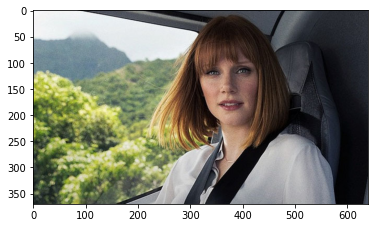

In [35]:
URL = 'http://d734df76.ngrok.io'

img = cv2.imread("drive/My Drive/FaceRecog/dataset/unknown/claire_dearing.jpg")
img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [0]:
# Add New User
r = requests.post(URL+'/add_user',{"username":"Anna","password":"12345"})
r.text

'{"status":0}'

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">\n<title>500 Internal Server Error</title>\n<h1>Internal Server Error</h1>\n<p>The server encountered an internal error and was unable to complete your request. Either the server is overloaded or there is an error in the application.</p>\n'

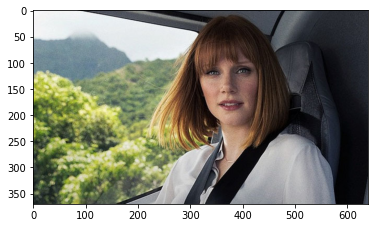

In [0]:
r = requests.post(URL+'/add',{"name":"Anna","image":image_2_dataURI(img),"username":"Anna","password":"12345"})
r.text

In [0]:
r = requests.post(URL+'/scan',{"image":image_2_dataURI(img),"username":"Anna","password":"12345"})
r.text

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">\n<title>500 Internal Server Error</title>\n<h1>Internal Server Error</h1>\n<p>The server encountered an internal error and was unable to complete your request. Either the server is overloaded or there is an error in the application.</p>\n'

In [0]:
r = requests.post(URL+'/remove',{"name":"Anna","username":"Anna","password":"12345"})
r.text

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">\n<title>500 Internal Server Error</title>\n<h1>Internal Server Error</h1>\n<p>The server encountered an internal error and was unable to complete your request. Either the server is overloaded or there is an error in the application.</p>\n'

In [0]:
data = get_data("Anshul Nagar","12345")
data

In [51]:
results = add_face("Anna",img)

[INFO] Scanning face...
[INFO] loading encodings...
[INFO] recognizing faces...
[INFO] Done !
[ERROR] Face already registered as name Anna


In [52]:
results

(0, 'Face already registered', 'Anna')